In [2]:
from PIL import Image
from google.colab import userdata
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import pandas as pd
import matplotlib.pyplot as plt

import json
import os

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    print(line)
    return



# Paths

In [3]:
project_path = userdata.get('PATH_PROJECT')
dataset_path = os.path.join(project_path, 'dataset')
metadata_path = os.path.join(dataset_path, 'dataset_metadata.json')


# Dataset / Dataloader

```
[
    {
        "unique_sample_id": "new_Fuziki_case10_2789_2650",
        "clean_image": 4547604,
        "distorted_image": 4547601,
        "score": 0,
        "metadata": {
            "crop_id": 4547601,
            "image_source": "Fuziki",
            "bp_case": "case10",
            "method": "new",
            "color": "RED",
            "score": 0,
            "roi": [
                    2650,
                    2789,
                    20,
                    20
                ],
            "bp_map": 4547603,
            "IQE_workspace_number": 990
        }
    }
]
```

In [5]:

class PairedImageDataset(Dataset):
    """
    Dataset that returns pairs of images (clean, new) or (clean, ref) along with their score label.

    Args:
        root_dir (str): Directory with subfolders 'clean', 'new', 'ref'.
        metadata_json_path (str): Path to JSON file of the form:
            [
                {
                    "unique_sample_id": "new_Fuziki_case10_2789_2650",
                    "clean_image": 4547604,
                    "distorted_image": 4547601,
                    "score": 0,
                    "metadata": {
                        ...
                    }
                },
                ...
            ]
        transform (callable, optional): Transform to apply to both images.
    """
    def __init__(self, root_dir, metadata_json_path, transform=transforms.ToTensor()):
        self.root_dir = root_dir
        self.transform = transform

        # Load metadata
        self.meta = pd.read_json(metadata_json_path)

        # Build list of (clean_path, other_path, score)
        self.samples = []
        for _, row in self.meta.iterrows():
            clean_id = str(row['clean_image'])
            distorted_id = str(row['distorted_image'])
            method = row['metadata']['method']
            score = row['score']

            # make triples (clean path, distorted path, score)
            clean_path = os.path.join(root_dir, 'clean', f'{clean_id}.png')
            distorted_path = os.path.join(root_dir, method, f'{distorted_id}.png')

            if os.path.exists(distorted_path):
                self.samples.append((clean_path, distorted_path, score))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        clean_path, other_path, score = self.samples[idx]
        img_clean = Image.open(clean_path)
        img_other = Image.open(other_path)

        if self.transform:
            img_clean = self.transform(img_clean)
            img_other = self.transform(img_other)

        return img_clean, img_other, score




Batch 0: clean torch.Size([16, 3, 20, 20]), paired torch.Size([16, 3, 20, 20]), scores tensor([0.5000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.5000, 0.0000, 0.0000,
        0.5000, 0.0000, 1.0000, 0.0000, 0.0000, 0.5000, 0.0000],
       dtype=torch.float64)


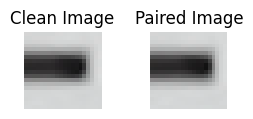

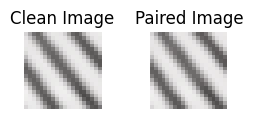

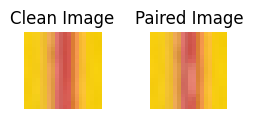

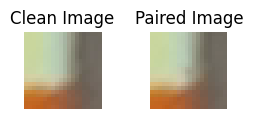

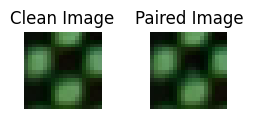

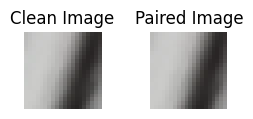

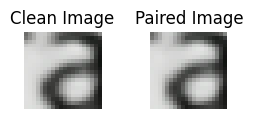

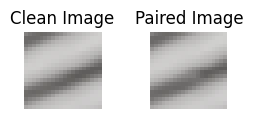

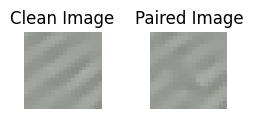

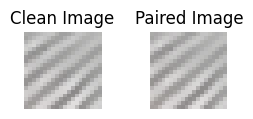

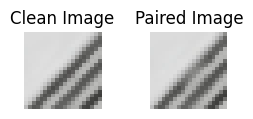

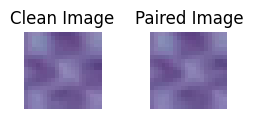

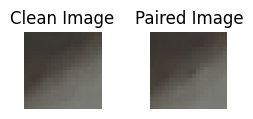

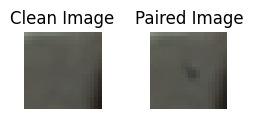

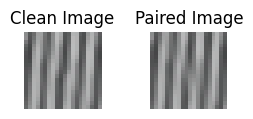

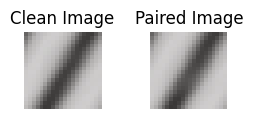

In [6]:
from torchvision.transforms.functional import to_pil_image

# Create dataset and dataloader
dataset = PairedImageDataset(dataset_path, metadata_path)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

# Iterate
for batch_idx, (clean_imgs, paired_imgs, scores) in enumerate(dataloader):
    print(f"Batch {batch_idx}: clean {clean_imgs.shape}, paired {paired_imgs.shape}, scores {scores}")
    # break after first batch
    for clean, distorted in zip(clean_imgs, paired_imgs):
        # Convert tensors to PIL Images
        clean_pil = to_pil_image(clean)
        distorted_pil = to_pil_image(distorted)

        # Create a figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(3, 1))

        # Display the images side by side
        axes[0].imshow(clean_pil)
        axes[0].set_title("Clean Image")
        axes[0].axis('off')

        axes[1].imshow(distorted_pil)
        axes[1].set_title("Paired Image")
        axes[1].axis('off')

        plt.show()
    break

# Train / Test Split

## Save

In [25]:
# %%skip Comment out skip to save train_test_split.json

from sklearn.model_selection import train_test_split

# Split the metadata
train_meta, test_meta = train_test_split(dataset.meta, test_size=0.2, random_state=42)

# Convert to list of dictionaries for JSON serialization
train_list = train_meta.to_dict('records')
test_list = test_meta.to_dict('records')

# Create the dictionary for saving
split_data = {"random_state": 42, "train": train_list, "test": test_list}

# Define the path to save the split
split_save_path = os.path.join(dataset_path, 'train_test_split.json')

# Save the split to a JSON file
with open(split_save_path, 'w') as f:
    json.dump(split_data, f, indent=4)
print(f"Train/test split saved to {split_save_path}")


Train/test split saved to /content/drive/MyDrive/Colab Notebooks/Samsung/dataset/train_test_split.json


## Confirm

In [26]:
# Define the path to the split file
split_save_path = os.path.join(dataset_path, 'train_test_split.json')

# Read the split file
with open(split_save_path, 'r') as f:
    split_data = json.load(f)

train_samples = split_data['train']
test_samples = split_data['test']

# Display the JSON entries
print(f'''
train: [{json.dumps(train_samples[0], indent=2)}]

test: [{json.dumps(test_samples[0], indent=2)}]
''')




train: [{
  "unique_sample_id": "new_RES40_case10_1528_6682",
  "clean_image": 4596520,
  "distorted_image": 4596517,
  "score": 1.0,
  "metadata": {
    "crop_id": 4596517,
    "image_source": "RES40",
    "bp_case": "case10",
    "method": "new",
    "color": "GREEN",
    "score": 1,
    "roi": [
      6682,
      1528,
      20,
      20
    ],
    "bp_map": 4596519,
    "IQE_workspace_number": 990
  }
}]
      
test: [{
  "unique_sample_id": "new_TE42_case17_4078_5534",
  "clean_image": 4567725,
  "distorted_image": 4567722,
  "score": 0.5,
  "metadata": {
    "crop_id": 4567722,
    "image_source": "TE42",
    "bp_case": "case17",
    "method": "new",
    "color": "ORANGE",
    "score": 0.5,
    "roi": [
      5534,
      4078,
      20,
      20
    ],
    "bp_map": 4567724,
    "IQE_workspace_number": 990
  }
}]



Displaying first 2 training samples:


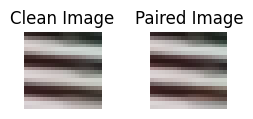

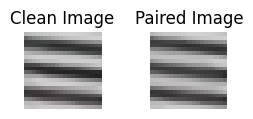


Displaying first 2 testing samples:


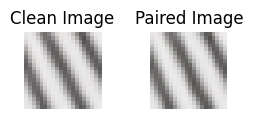

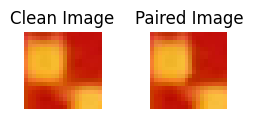

In [10]:
# Display the first 2 crops from train
print("Displaying first 2 training samples:")
for i in range(min(2, len(train_samples))):
    sample = train_samples[i]
    clean_id = str(sample['clean_image'])
    distorted_id = str(sample['distorted_image'])
    method = sample['metadata']['method']

    clean_path = os.path.join(dataset_path, 'clean', f'{clean_id}.png')
    distorted_path = os.path.join(dataset_path, method, f'{distorted_id}.png')

    if os.path.exists(clean_path) and os.path.exists(distorted_path):
        img_clean = Image.open(clean_path)
        img_other = Image.open(distorted_path)

        fig, axes = plt.subplots(1, 2, figsize=(3, 1))
        axes[0].imshow(img_clean)
        axes[0].set_title("Clean Image")
        axes[0].axis('off')
        axes[1].imshow(img_other)
        axes[1].set_title("Paired Image")
        axes[1].axis('off')
        plt.show()
    else:
        print(f"Image files not found for sample {sample['unique_sample_id']}")


# Display the first 2 crops from test
print("\nDisplaying first 2 testing samples:")
for i in range(min(2, len(test_samples))):
    sample = test_samples[i]
    clean_id = str(sample['clean_image'])
    distorted_id = str(sample['distorted_image'])
    method = sample['metadata']['method']

    clean_path = os.path.join(dataset_path, 'clean', f'{clean_id}.png')
    distorted_path = os.path.join(dataset_path, method, f'{distorted_id}.png')

    if os.path.exists(clean_path) and os.path.exists(distorted_path):
        img_clean = Image.open(clean_path)
        img_other = Image.open(distorted_path)

        fig, axes = plt.subplots(1, 2, figsize=(3, 1))
        axes[0].imshow(img_clean)
        axes[0].set_title("Clean Image")
        axes[0].axis('off')
        axes[1].imshow(img_other)
        axes[1].set_title("Paired Image")
        axes[1].axis('off')
        plt.show()
    else:
        print(f"Image files not found for sample {sample['unique_sample_id']}")